# Exercise Sheet 6 - Variational Autoencoders

 * Deep Learning for Computer Vision – Winter Term 2022/23
 * Organizers: Anwai Archit, Laura Hansel, Michaela Vystrcilova, Constantin Pape
 * Tutors: Anwai Archit, Mai Elshazly, Andreas Schneider, Fabio Seel, Shashwat Sridhar
 * Due date: **Mon, Jan 30, before 14:00**

In this exercise a variational autoencoder (VAE) shall be implemented and trained on the fashion MNIST dataset. VAEs are an example of generative deep learning and can be used to synthesize data - images in this case - which shall also be demonstrated in this exercise!

### IMPORTANT SUBMISSION INSTRUCTIONS

- When you're done, download the notebook and rename it to ```<surname1>_<surname2>_<surname3>.ipynb```
- Only submit the Jupyter Notebook (ipynb file). No other file is required. Upload it on `Stud.IP` -> `Deep Learning for Computer Vision` -> `Files` -> `Submission of Homework 6`
- Make only one submission of the exercise per group.
- The deadline is strict
- In addition to the submission, every member of your group should be prepared to present the exercise in the tutorials.

### TASKS
* TASK 1: Implement a VAE
* TASK 2: Train the model and plot train+test set loss over training in the same plot
* TASK 3: Determine optimal dimensionality of latent space
* TASK 4: Plot some latent traversals
* TASK 5: Visualize class labels in latent space

## Setup and Requirements

### Imports

In [20]:
from __future__ import print_function
import pathlib

import matplotlib.pyplot as plt

import torch
import torch.utils.data

from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
import torchvision.utils

import numpy as np

!nvcc --version
!python --version
print(torch.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0
Python 3.7.12
1.11.0


### Basic setup

Define various global parameters used throughout the notebook!

In [21]:
# Try to use GPU if available
use_cuda = True

# Path for data
data_dir = pathlib.Path('data/')

# Batch size
batch_size = 128

# Image size (same size in both dimensions)
image_size = 28

# Dimension of the latent space
latent_space_dim = 10

# Number of epochs to train
epochs = 5

# Channels in the convolutional layers
capacity = 32

# Learning rate for the optimizer
learning_rate = 1e-3

# Define size / zoom level of plots
plot_zoom = 2
plot_w, plot_h = plt.figure().get_size_inches()
plot_w = plot_w * plot_zoom
plot_h = plot_h * plot_zoom

<Figure size 432x288 with 0 Axes>

Test if a GPU (CUDA) is available in the environment and use it if it is. Otherwise use the CPU.

In [22]:
if use_cuda and not torch.cuda.is_available():
    print("Error: cuda requested but not available, will use cpu instead!")
    device = torch.device('cpu')
elif not use_cuda:
    print("Info: will use cpu!")
    device = torch.device('cpu')
else:
    print("Info: cuda requested and available, will use gpu!")
    device = torch.device('cuda')


Info: cuda requested and available, will use gpu!


## Get and preprocess the data


We will use the FashionMNIST data set from Zalando (https://github.com/zalandoresearch/fashion-mnist) for our experiments.  
From the quoted github-repo: "Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits."


### Load the data for training and testing

The FashionMNIST dataset is already included in the torchvision datasets with the approriate training and test splits. Run the cell below to use it in this notebook.

In [23]:
data_dir = pathlib.Path('data/')
mnist = datasets.FashionMNIST(data_dir, download=True, train=True)

In [24]:
mnist = datasets.FashionMNIST(data_dir, download=True, train=True, transform=transforms.ToTensor())
tmp_dataloader = torch.utils.data.DataLoader(mnist, batch_size=len(mnist), shuffle=True)
samples,_ = next(iter(tmp_dataloader))
mean = samples[:,:,:].mean()
std = samples[:,:,:].std()

In [25]:
mnist_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((mean,), (std,))])

In [26]:
# Load the datasets similar like you did with standard MNIST before
train_dataset = datasets.FashionMNIST(data_dir, download=True, train=True, transform=mnist_transforms)
test_dataset  = datasets.FashionMNIST(data_dir, download=True, train=False, transform=mnist_transforms)

For comparison, you can also use the well known MNIST dataset, which is also already included in the torchvision datasets with the approriate training and test splits. Just run the cell included in the appendix instead if you want to use it in this notebook.

Define data loaders for the training and test sets which return batches of samples.

In [27]:
# Define the data loaders
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size,shuffle=True)

### Plot the data

To get an impression of the dataset plot some random exemplary pictures.

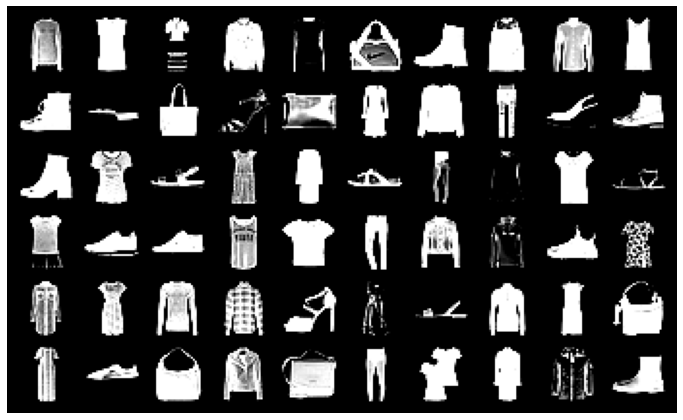

In [28]:
images_columns = 10
images_rows    = 6

def show_grid(images_tensor, images_columns, images_rows):
    image = torchvision.utils.make_grid(images_tensor, images_columns, images_rows)
    image = image.numpy()
    fig = plt.gcf()
    fig.set_size_inches(plot_w, plot_h)
    plt.axis('off')
    plt.imshow(np.transpose(image, (1, 2, 0)))
    plt.show()

data_iterator = iter(train_loader)
images, labels = data_iterator.next()

show_grid(images[0:(images_columns * images_rows)], images_columns, images_rows)


## Implement a convolutional Variational Autoencoder (VAE)

### Implement the network architecture

Recall that a VAE roughly consistst of two parts: The encoder (which reduces the number of dimensions and maps the input to the latent space) and the decoder (which reverses the encoding, mapping from the latent space back to the initial space).

In VAEs (compared to standard auto-encoders) we assume that the latent space is generated from a multi-variate normal distribution (N~(μ, Σ)) that is parameterized by two vectors, mean and variance. In the network, we use the log of the variance. 

In training, we sample from the distribution using the current values of the two vectors, which are updated in each step. After training, we use the mu value to draw the samples.

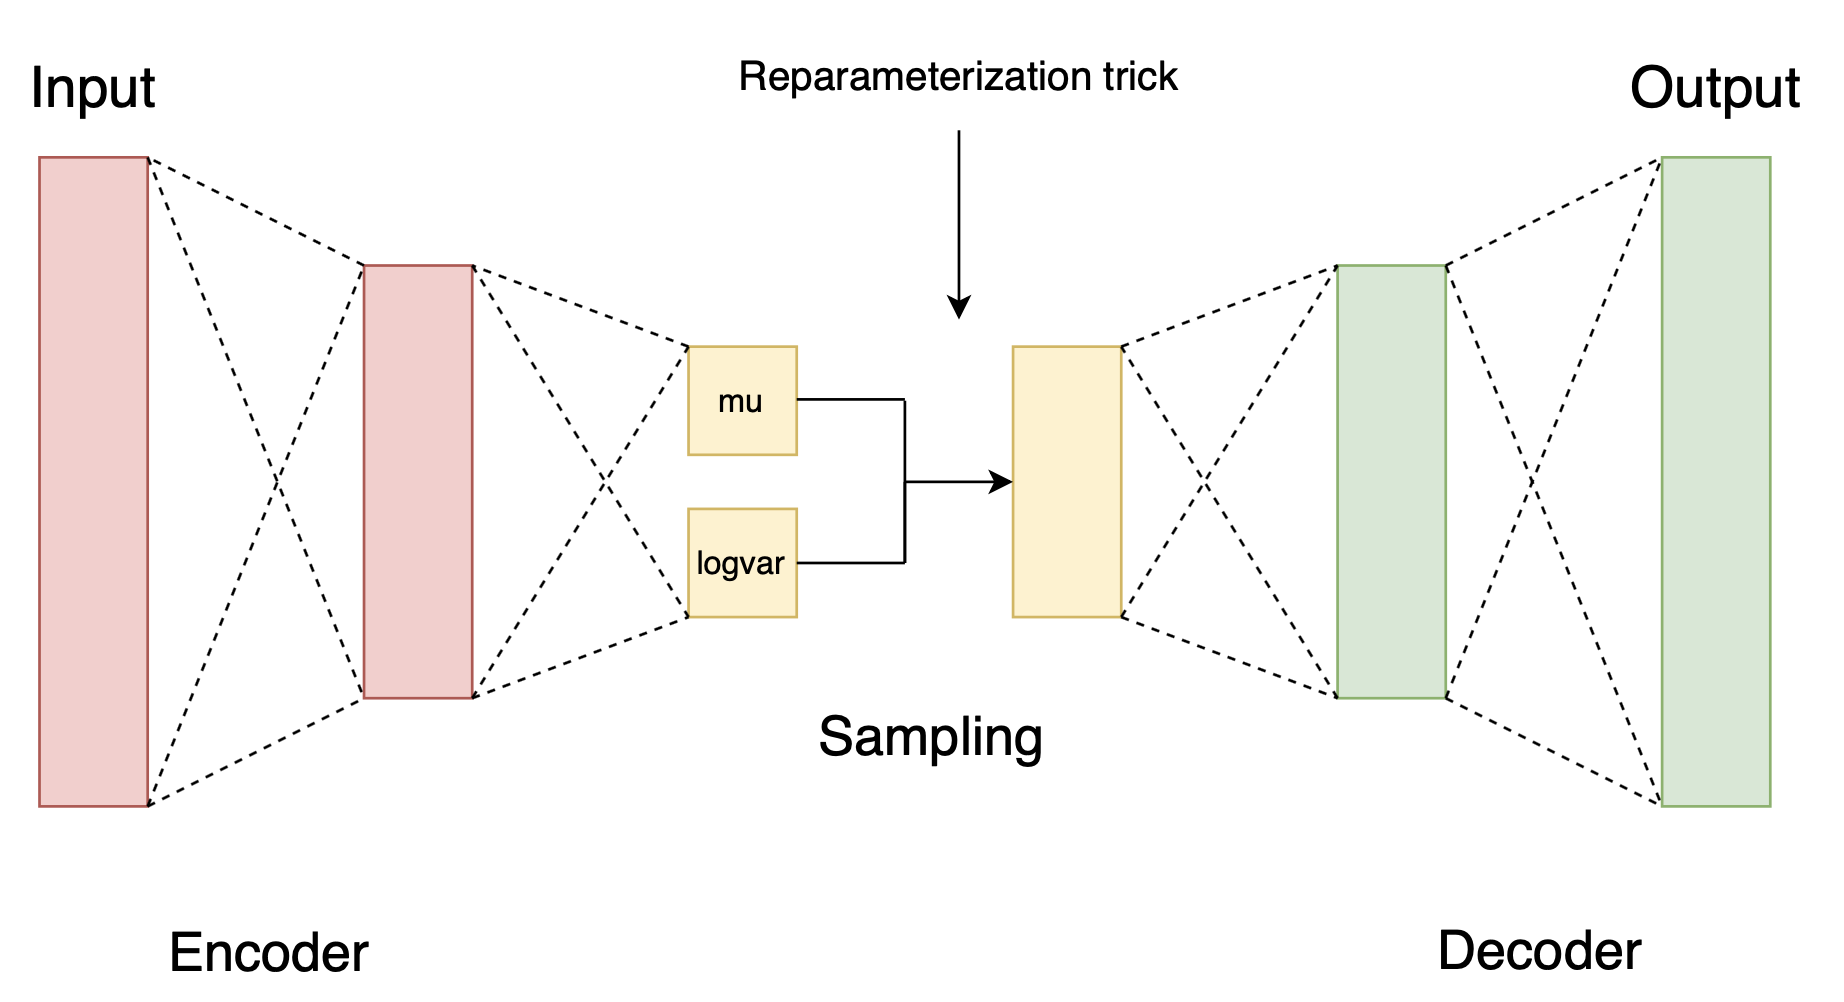

**TASK 1: Implement a VAE with the following network architecture**

We will implement a basic convolutional VAE architecture. Look at the following VAE class specification and implement it accordingly: 

**Encoder (sequential model):**
 * Convolutional Layer with (1, capacity) number of (in, out)-channels, kernel size of 4 * 4, stride of 2 and padding of 1
 * ReLU Activation Layer
 * Convolutional Layer with (capacity, 2 * capacity) number of (in, out)-channels, kernel size of 4 * 4, stride of 2 and padding of 1
 * ReLU Activation Layer
 
**Sampling:**
* mu, logvar: Linear Layer with 2 * capacity * 7 * 7 input features and latent_dims output features each 
* z: Linear Layer with latent_dims input features and 2 * capacity * 7 * 7 output features

**Decoder (sequential model):**
 * ConvTranspose2d Layer with (2 * capacity, capacity) number of (in, out)-channels, kernel size of 4 * 4, stride of 2 and padding of 1 
 * ReLU Activation Layer
 * ConvTranspose2d Layer with (capacity, 1) number of (in, out)-channels, kernel size of 4 * 4, stride of 2 and padding of 1 
 * Sigmoid Activation Layer



**Hint**

For the sampling use the reparameterization trick:

To generate x ~ N(μ, σ²), sample ε ~ N(0, 1). Then x can be computed as x = μ + σε.

Further, remember to differentiate between training and eval: sample in training and return mu in eval.

**TODO** What does the reparameterization trick do and why do we need it?
**YOUR ANSWER**
- its used to be able to propagate gradients in training.
- since plus and * operations are differentiable, but sampling function isnt.

In [29]:
# TODO Implement the VAE
class VAE(nn.Module):
    def __init__(self,capacity=32,latent_dim=10):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1,capacity,4,2,1),
            nn.ReLU(),
            nn.Conv2d(capacity,2*capacity,4,2,1),
            nn.ReLU()
        )
        self.linear_mu = nn.Linear(2*capacity*7*7,latent_dim)
        self.linear_logvar = nn.Linear(2*capacity*7*7,latent_dim)
        self.linear_out = nn.Linear(latent_dim,2*capacity*7*7)
        self.decoder = nn.Sequential(
            #nn.Linear(latent_dim,2*capacity*7*7),
            #nn.Unflatten(1,(-1,2*capacity,7,7)), 
            nn.ConvTranspose2d(2*capacity,capacity,4,2,1),
            nn.ReLU(),
            nn.ConvTranspose2d(capacity,1,4,2,1),
            nn.Sigmoid()                
        )
        self.mu_val = 0
        self.logvar_val = 1
        
    def sample(mu,var):
        sample_vec = torch.normal(0,1,size=(mu.shape[-2],1))
        return mu+sample_vec*var
    def forward(self,x):
        x = self.encoder(x)
        m = nn.Flatten()
        mu = self.linear_mu(m(x))
        self.mu_val = mu
        logvar = self.linear_logvar(m(x))
        self.logvar_val = logvar
        #sample_vec = torch.normal(0,1,size=mu.shape)
        sample_vec = torch.randn_like(logvar)
        x = mu+sample_vec.to(device)*logvar.exp()
        x = self.linear_out(x)
        x = x.reshape(-1,2*capacity,7,7)
        x = self.decoder(x)
        return x

### Implement the loss function

Implement the two parts of the loss function: reconstruction loss using Mean Squared Error (MSE) function and the regularization part of the loss using Kullback-Leibler-Divergence (KLD).

**Hint:** Make sure that you use sum instead of mean for calculating the MSE loss!

In [30]:
def vae_loss(recon_x, x, mu, logvar):
    # Reconstruction losses are calculated using Mean Squared Error (MSE) and 
    # summed over all elements and batch
    mse_loss = nn.functional.mse_loss(recon_x,x,reduction='sum')
    # See Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    kl_loss = nn.KLDivLoss()
    #kld_loss = torch.distributions.kl_divergence(recon_x, x)
    sample1 = torch.randn(size=mu.shape).to(device)
    sample2 = torch.randn(size=mu.shape).to(device)
    latent_vec = mu+logvar.exp()*sample1
    #kld_loss = kl_loss(latent_vec,sample2)
    kld_loss = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))
    total_loss = mse_loss + 10*kld_loss
    return total_loss, mse_loss, kld_loss

### Instantiate the model and define the optimizer to use.

In [31]:
model = VAE()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [32]:
model

VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
  )
  (linear_mu): Linear(in_features=3136, out_features=10, bias=True)
  (linear_logvar): Linear(in_features=3136, out_features=10, bias=True)
  (linear_out): Linear(in_features=10, out_features=3136, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): Sigmoid()
  )
)

## Train the network

**TASK 2: Train the model and plot train+test set loss over training in the same plot**


In [33]:
import tqdm

In [34]:
def train_epoch(model, loader, loss, metric, optimizer):
    model.train()
    epoch_loss = []
    for i, (x, y) in enumerate(loader):
        optimizer.zero_grad()
        y = x #for reconstruction
        x, y = x.to(device,dtype=torch.float), y.to(device,dtype=torch.float)
        pred = model(x)
        mu = model.mu_val
        logvar = model.logvar_val
        loss_value,_,_ = loss(pred, y.float(),mu,logvar)
        loss_value.backward()
        optimizer.step()
        if metric is not None:
            metric_value = metric(pred, y)
        epoch_loss.append(loss_value.detach().cpu())
    return np.mean(epoch_loss)
# validate the model
def validate(model, loader, loss, metric):
    model.eval()
    n_val = len(loader)
    metric_value, loss_value = 0.0, 0.0
    #kld_loss = 0
    #mse_loss = 0
    with torch.no_grad():
        for x, y in loader:
            y = x #for reconstruction
            x, y = x.to(device), y.to(device)
            pred = model(x.float()) #add float
            mu = model.mu_val
            logvar = model.logvar_val
            loss_epoch,mse,kld = loss(pred, y.float(),mu,logvar)
            #kld_loss+=kld
            #mse_loss+=mse
            loss_value += loss_epoch
    #print("mse:",mse_loss/n_val,"\tkld:",kld_loss/n_val)
    metric_value /= n_val
    loss_value /= n_val
    return loss_value

# run the whole training
def run_training(
    model, train_loader, val_loader, loss, optimizer, n_epochs,metric=None
):
    epoch_len = len(train_loader)
    step = 0
    for epoch in tqdm.trange(n_epochs):
        print("Epoch:",epoch)
        test_loss = train_epoch(model, train_loader, loss, metric, optimizer)
        step = epoch_len * (epoch + 1)
        val_loss = validate(model, val_loader, loss, metric)
        print(f'Train loss: {test_loss:.2f}, Test loss: {val_loss:.2f}')

In [35]:
n_epochs = 5
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss = vae_loss
run_training(model, train_loader, test_loader, loss, optimizer, 5)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0


 20%|██        | 1/5 [00:14<00:59, 14.75s/it]

Train loss: 69566.19, Test loss: 60196.36
Epoch: 1


 40%|████      | 2/5 [00:30<00:46, 15.35s/it]

Train loss: 60491.86, Test loss: 59241.82
Epoch: 2


 60%|██████    | 3/5 [00:45<00:30, 15.14s/it]

Train loss: 59854.21, Test loss: 58835.16
Epoch: 3


 80%|████████  | 4/5 [01:00<00:15, 15.21s/it]

Train loss: 59485.90, Test loss: 58534.27
Epoch: 4


100%|██████████| 5/5 [01:15<00:00, 15.16s/it]

Train loss: 59210.47, Test loss: 58465.84


### Visualization of random samples from the latent space

Here we create a number of random samples from the latent space and use the decoder to generate images from them. Rerun the code cell to generate new samples every time!

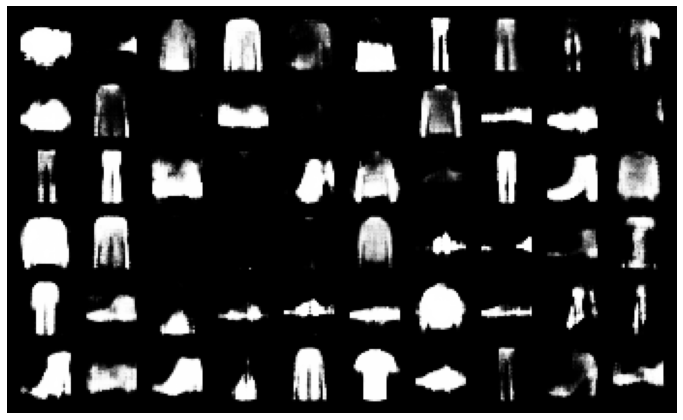

In [36]:
with torch.no_grad():
    samples = torch.randn(images_columns * images_rows, 64,latent_space_dim).to(device)
    samples = model.linear_out(samples)
    samples = samples.reshape(-1,2*32,7,7)
    samples = model.decoder(samples).cpu()
    show_grid(samples[0:(images_columns * images_rows)], images_columns, images_rows)

### Visualization of image reconstructions

Visualize the image reconstruction process and compare the reconstructions to the original images.

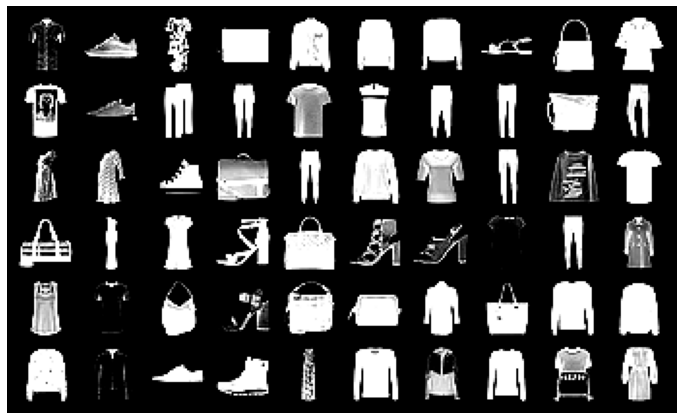

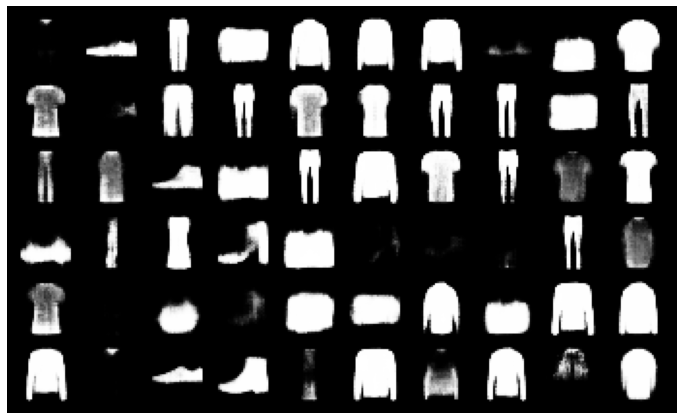

In [37]:
images_columns = 10
images_rows    = 6

data_iterator = iter(train_loader)
images, labels = data_iterator.next()

# Show original images
show_grid(images[0:(images_columns * images_rows)], images_columns, images_rows)

# Show reconstructed images
model.eval()
with torch.no_grad():

    # TODO: compute reconstruction
    images_recon = model(images.to(device)).detach().cpu()

    show_grid(images_recon[0:(images_columns * images_rows)], images_columns, images_rows)


### Optimization

**TASK 3: Explore dimensionality of latent space**

How does the dimensionality of latent space (set to 10 by default in our case) affect loss and quality of the reconstructions? Explore smaller and larger latent dimensionality by using 2, 4, 8, 16, 32 dimensions and looking at reconstructions and resulting test set losses.

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0


 20%|██        | 1/5 [00:15<01:02, 15.67s/it]

Train loss: 71378.80, Test loss: 61855.43
Epoch: 1


 40%|████      | 2/5 [00:31<00:46, 15.66s/it]

Train loss: 62235.21, Test loss: 60870.86
Epoch: 2


 60%|██████    | 3/5 [00:46<00:30, 15.32s/it]

Train loss: 61556.76, Test loss: 60479.21
Epoch: 3


 80%|████████  | 4/5 [01:00<00:15, 15.07s/it]

Train loss: 61183.96, Test loss: 60128.23
Epoch: 4


100%|██████████| 5/5 [01:16<00:00, 15.23s/it]

Train loss: 60920.09, Test loss: 60060.93
original image


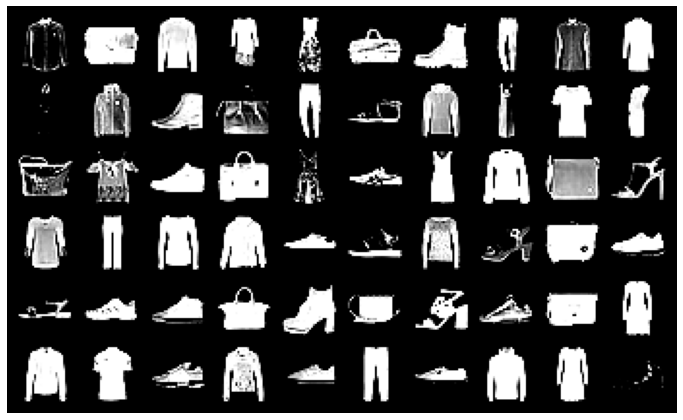

reconstructed image with model latent dim=2


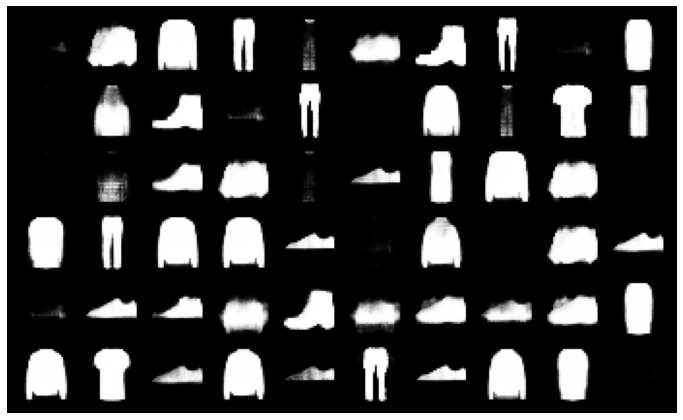

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0


 20%|██        | 1/5 [00:14<00:58, 14.59s/it]

Train loss: 68090.41, Test loss: 60336.39
Epoch: 1


 40%|████      | 2/5 [00:29<00:43, 14.61s/it]

Train loss: 60506.70, Test loss: 59266.77
Epoch: 2


 60%|██████    | 3/5 [00:44<00:30, 15.06s/it]

Train loss: 59747.71, Test loss: 58804.26
Epoch: 3


 80%|████████  | 4/5 [01:00<00:15, 15.19s/it]

Train loss: 59295.20, Test loss: 58395.50
Epoch: 4


100%|██████████| 5/5 [01:15<00:00, 15.14s/it]

Train loss: 59009.46, Test loss: 58101.94
original image


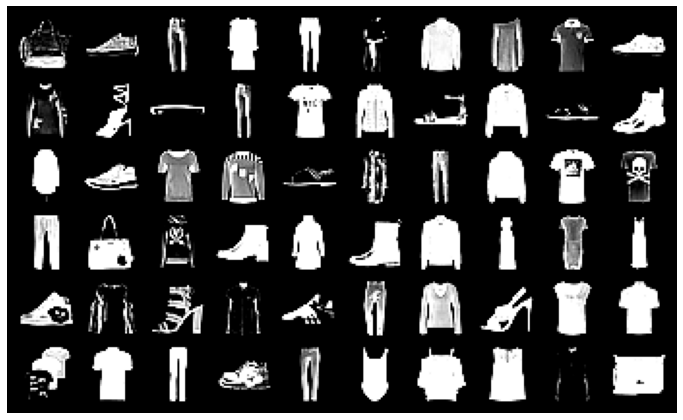

reconstructed image with model latent dim=4


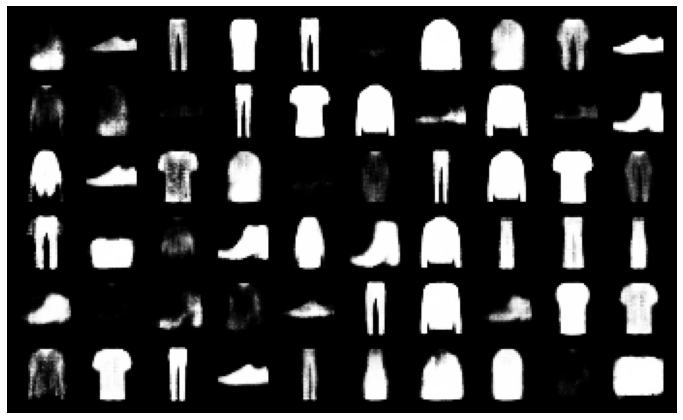

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0


 20%|██        | 1/5 [00:14<00:59, 14.94s/it]

Train loss: 68129.98, Test loss: 60204.29
Epoch: 1


 40%|████      | 2/5 [00:30<00:45, 15.13s/it]

Train loss: 60540.07, Test loss: 59455.38
Epoch: 2


 60%|██████    | 3/5 [00:45<00:30, 15.15s/it]

Train loss: 59935.09, Test loss: 58907.79
Epoch: 3


 80%|████████  | 4/5 [01:00<00:15, 15.17s/it]

Train loss: 59515.59, Test loss: 58547.69
Epoch: 4


100%|██████████| 5/5 [01:15<00:00, 15.16s/it]

Train loss: 59226.21, Test loss: 58268.57
original image


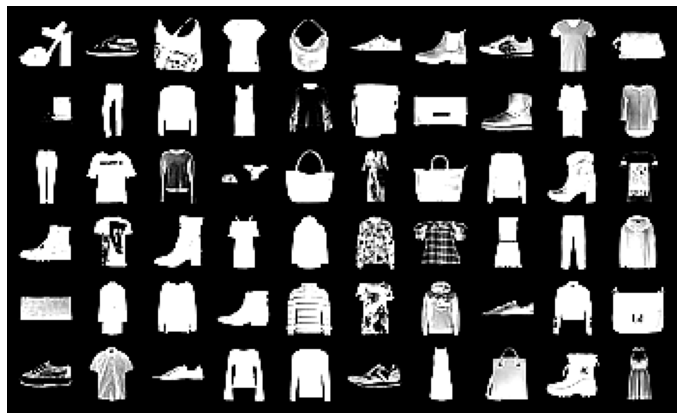

reconstructed image with model latent dim=8


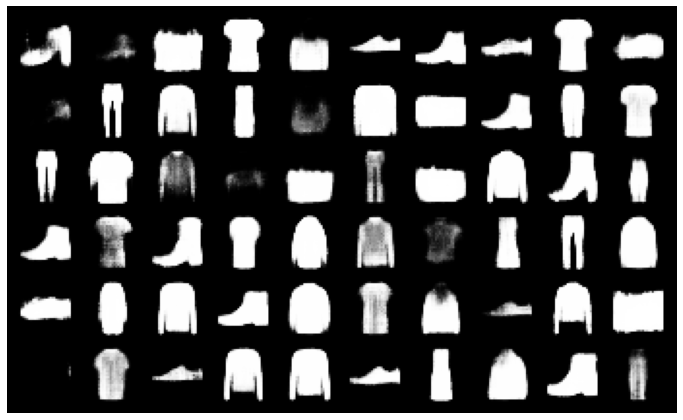

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0


 20%|██        | 1/5 [00:15<01:00, 15.18s/it]

Train loss: 68665.18, Test loss: 60605.40
Epoch: 1


 40%|████      | 2/5 [00:30<00:45, 15.21s/it]

Train loss: 60718.18, Test loss: 59433.00
Epoch: 2


 60%|██████    | 3/5 [00:45<00:30, 15.32s/it]

Train loss: 60018.87, Test loss: 58967.23
Epoch: 3


 80%|████████  | 4/5 [01:00<00:15, 15.11s/it]

Train loss: 59600.24, Test loss: 58686.41
Epoch: 4


100%|██████████| 5/5 [01:16<00:00, 15.23s/it]

Train loss: 59355.97, Test loss: 58409.15
original image


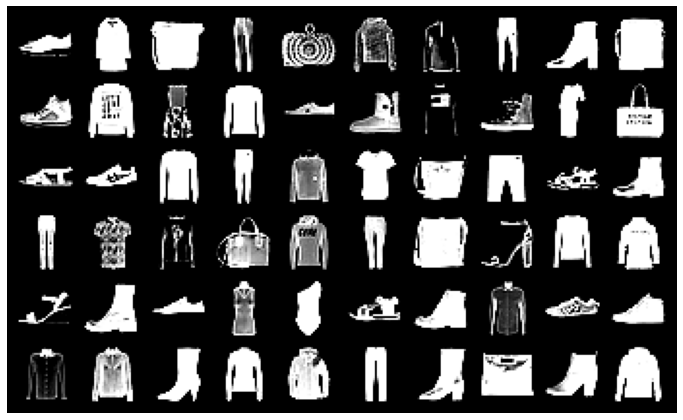

reconstructed image with model latent dim=16


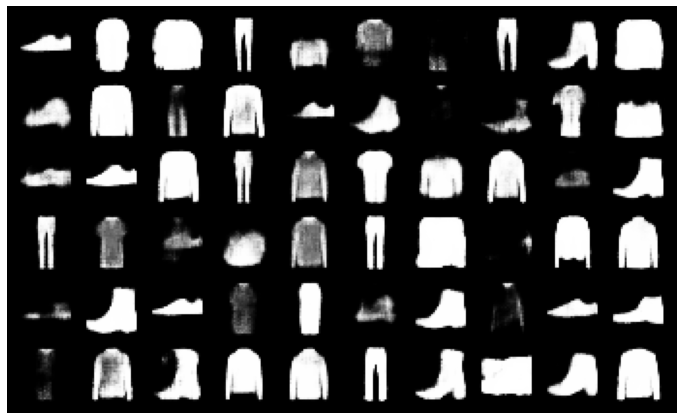

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0


 20%|██        | 1/5 [00:14<00:59, 14.84s/it]

Train loss: 70816.72, Test loss: 61050.21
Epoch: 1


 40%|████      | 2/5 [00:29<00:45, 15.02s/it]

Train loss: 61072.27, Test loss: 59812.57
Epoch: 2


 60%|██████    | 3/5 [00:45<00:30, 15.02s/it]

Train loss: 60284.96, Test loss: 59197.08
Epoch: 3


 80%|████████  | 4/5 [01:00<00:15, 15.07s/it]

Train loss: 59863.03, Test loss: 58997.40
Epoch: 4


100%|██████████| 5/5 [01:14<00:00, 14.94s/it]

Train loss: 59580.32, Test loss: 58714.82
original image


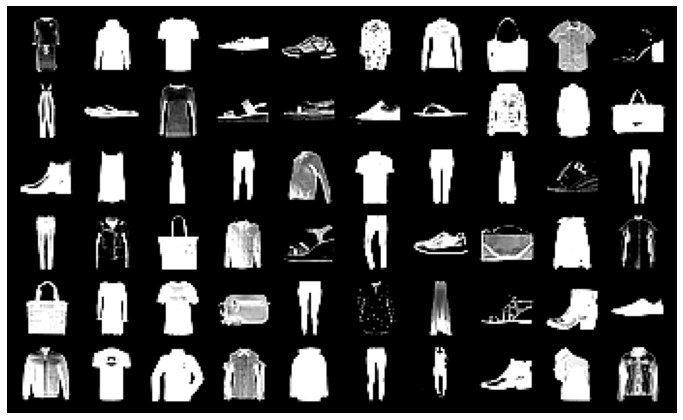

reconstructed image with model latent dim=32


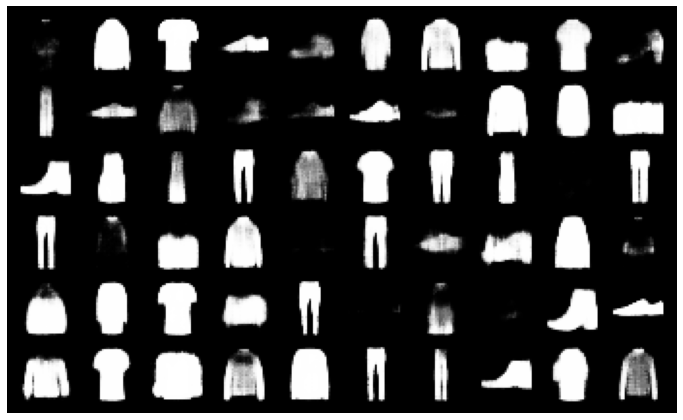

In [38]:
# TODO
models = {}
for latent in [2,4,8,16,32]:
    n_epochs = 5
    model_ac = VAE(latent_dim=latent).to(device)
    optimizer = torch.optim.Adam(model_ac.parameters(), lr=1e-3)
    loss = vae_loss
    run_training(model_ac, train_loader, test_loader, loss, optimizer, n_epochs)
    models["model_latent_"+str(latent)]=model_ac
    data_iterator = iter(train_loader)
    images, labels = data_iterator.next()

    # Show original images
    print(f"original image")
    show_grid(images[0:(images_columns * images_rows)], images_columns, images_rows)

    # Show reconstructed images
    model_ac.eval()
    with torch.no_grad():

        # TODO: compute reconstruction
        print(f"reconstructed image with model latent dim={latent}")
        images_recon = model_ac(images.to(device)).detach().cpu()

        show_grid(images_recon[0:(images_columns * images_rows)], images_columns, images_rows)

## Visualization of latent traversals

**TASK 4: Plot some latent traversals**

Latent traversal is a popular approach to visualize the disentangled latent representations. Given a bunch of variations in a single unit of the latent representation, it is expected that there is a change in a single factor of variation of the data while others are fixed. (See paper [Learning Disentangled Representations with Latent Variation Predictability](https://arxiv.org/abs/2007.12885))

Remember in the previous task you trained models with different latent dimensions. Each shape is encoded into a `latent_dim`-sized vector. In this task we want to see which shapes are reconstructed if we create a latent code where we set

- one of these dimensions (e.g. dim1=11) to different values ($x_i \in [-3,3]$)
- two of these dimensions (e.g. dim1=31, dim2=4) to different values ($x_i, x_j \in [-3,3]$)

while setting all other values of the latent code to $0$. Use the decoder of the VAE neural network to create images from these latent codes.

**TODO** Create a 1 x 10 array plot for the first visualization and a 10 x 10 matrix plot for the second showing latent space travels.

**TODO** Repeat the experiment, now setting the other dimensions of the vector to a random value in [-1,1] instead of zero. Write down what you observe.

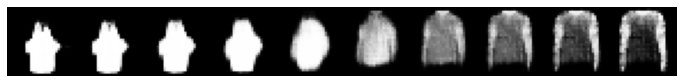

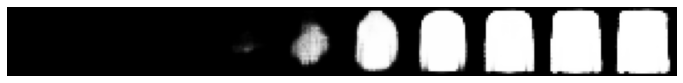

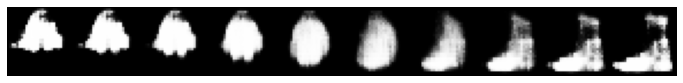

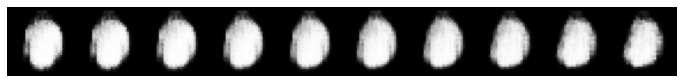

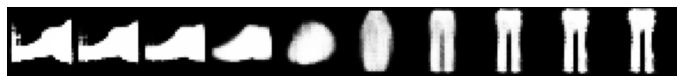

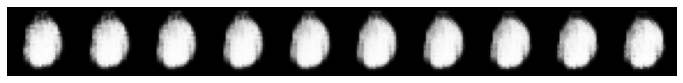

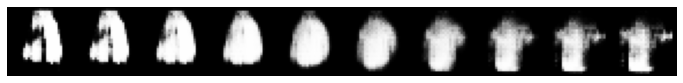

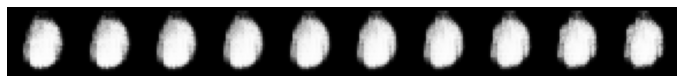

In [39]:
with torch.no_grad():
    for j in range(8):
        traveler = torch.zeros(10,10)
        values = torch.linspace(-3,3,10)
        for i in range(10):
            traveler[i][j]+=values[i]
        traveler = traveler.to(device)
        model32 = models['model_latent_16']
        model32=model
        samples = model32.linear_out(traveler)
        samples = samples.reshape(-1,2*32,7,7)
        samples = model32.decoder(samples).cpu()
        show_grid(samples[0:(10 * 1)], 10, 1)

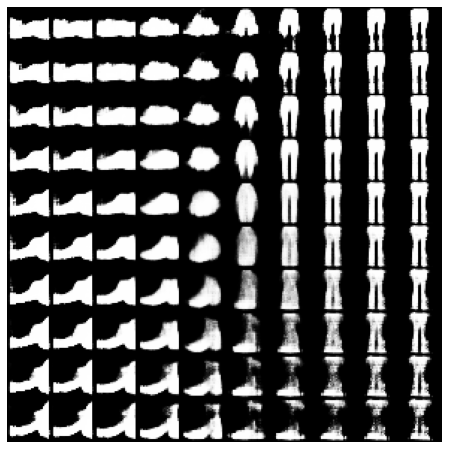

In [52]:
with torch.no_grad():
    traveler = torch.zeros(10,10,10)
    values = torch.linspace(-3,3,10)
    for i in range(10):
        for j in range(10):
            traveler[i][j][4]=values[j]
            traveler[i][j][2]=values[i]
    traveler = traveler.to(device)
    #model32 = models['model_latent_16']
    model32=model
    samples = model32.linear_out(traveler)
    samples = samples.reshape(-1,2*32,7,7)
    samples = model32.decoder(samples).cpu()
    show_grid(samples[0:(10 * 10)], 10, 1)

Here are two examples.

1x10 traversal of one latent dimension

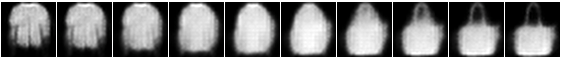

10x10 traversal of two latent dimensions

![10x10 traversal of two latent dimensions](https://i.imgur.com/hZXIYzv.png)

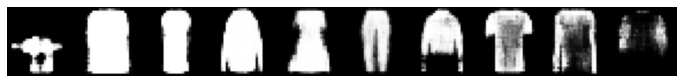

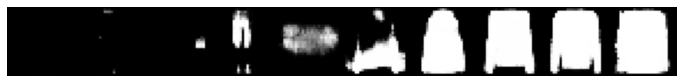

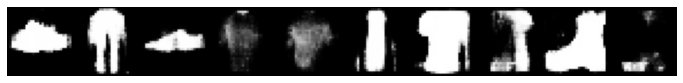

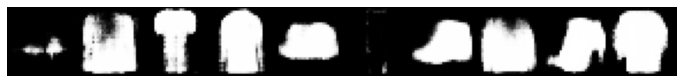

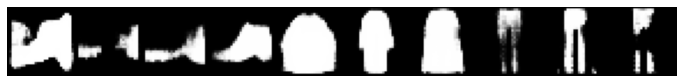

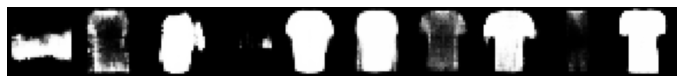

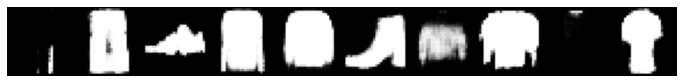

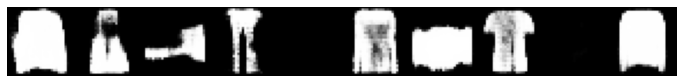

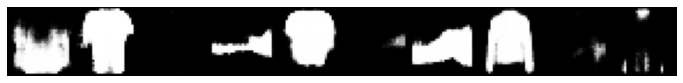

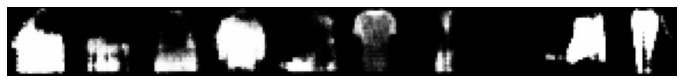

In [41]:
with torch.no_grad():
    for j in range(10):
        traveler = torch.randn(10,10)
        values = torch.linspace(-3,3,10)
        for i in range(10):
            traveler[i][j]=values[i]
        traveler = traveler.to(device)
        model32 = models['model_latent_2']
        model32=model
        samples = model32.linear_out(traveler)
        samples = samples.reshape(-1,2*32,7,7)
        samples = model32.decoder(samples).cpu()
        show_grid(samples[0:(10 * 1)], 10, 1)

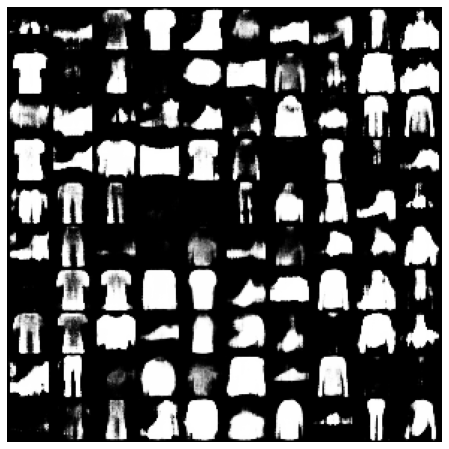

In [42]:
with torch.no_grad():
    traveler = torch.randn(10,10,10)
    values = torch.linspace(-3,3,10)
    for i in range(10):
        for j in range(10):
            traveler[i][j][8]=values[j]
            traveler[i][j][3]=values[i]
    traveler = traveler.to(device)
    #model32 = models['model_latent_16']
    model32=model
    samples = model32.linear_out(traveler)
    samples = samples.reshape(-1,2*32,7,7)
    samples = model32.decoder(samples).cpu()
    show_grid(samples[0:(10 * 10)], 10, 1)

### Visualize class labels in latent space

**TASK 5: Visualize class labels in latent space**

First create a new VAE-model with a 2d latent space on the full training data set. Then project all the images of the training set into the 2d latent space keeping track of their class labels. Use a 2d scatter plot to visualize the resulting latent space vectors and different colors for their labels. 

- Do images of the same class cluster in latent space?
- Do the data points in latent space look like a normal distribution?

#### Train 2d latent space model

In [43]:
n_epochs = 5
model_2d = VAE(latent_dim=2).to(device)
optimizer = torch.optim.Adam(model_2d.parameters(), lr=1e-3)
loss = vae_loss
run_training(model_2d, train_loader, test_loader, loss, optimizer, 5)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0


 20%|██        | 1/5 [00:15<01:00, 15.00s/it]

Train loss: 72007.78, Test loss: 64539.31
Epoch: 1


 40%|████      | 2/5 [00:29<00:44, 14.74s/it]

Train loss: 64476.14, Test loss: 62785.61
Epoch: 2


 60%|██████    | 3/5 [00:45<00:30, 15.30s/it]

Train loss: 63242.68, Test loss: 61919.93
Epoch: 3


 80%|████████  | 4/5 [01:00<00:15, 15.25s/it]

Train loss: 62197.87, Test loss: 60541.73
Epoch: 4


100%|██████████| 5/5 [01:16<00:00, 15.22s/it]

Train loss: 61233.54, Test loss: 60124.96


In [45]:
n = len(train_dataset)
latent_val = np.zeros((n,2))
labels = np.zeros(n)
ind = 0
with torch.no_grad():
    for i, (x, y) in enumerate(train_loader):
        x, y = x.to(device,dtype=torch.float), y
        num = x.shape[0]
        x = model_2d.encoder(x)
        m = nn.Flatten()
        mu = model_2d.linear_mu(m(x))
        logvar = model_2d.linear_logvar(m(x))
        sample_vec = torch.normal(0,1,size=(mu.shape[-2],1))
        z = mu+sample_vec.to(device)*logvar.exp()
        latent_val[ind:ind+num,:]=z.detach().cpu().numpy()
        labels[ind:ind+num]=y
        ind=ind+num

In [46]:
from matplotlib import colors
def get_random_colors(labels):
    n_labels = len(np.unique(labels)) - 1
    cmap = [[0, 0, 0]] + np.random.rand(n_labels, 3).tolist()
    cmap = colors.ListedColormap(cmap)
    return cmap
cmap = get_random_colors(np.unique(labels))

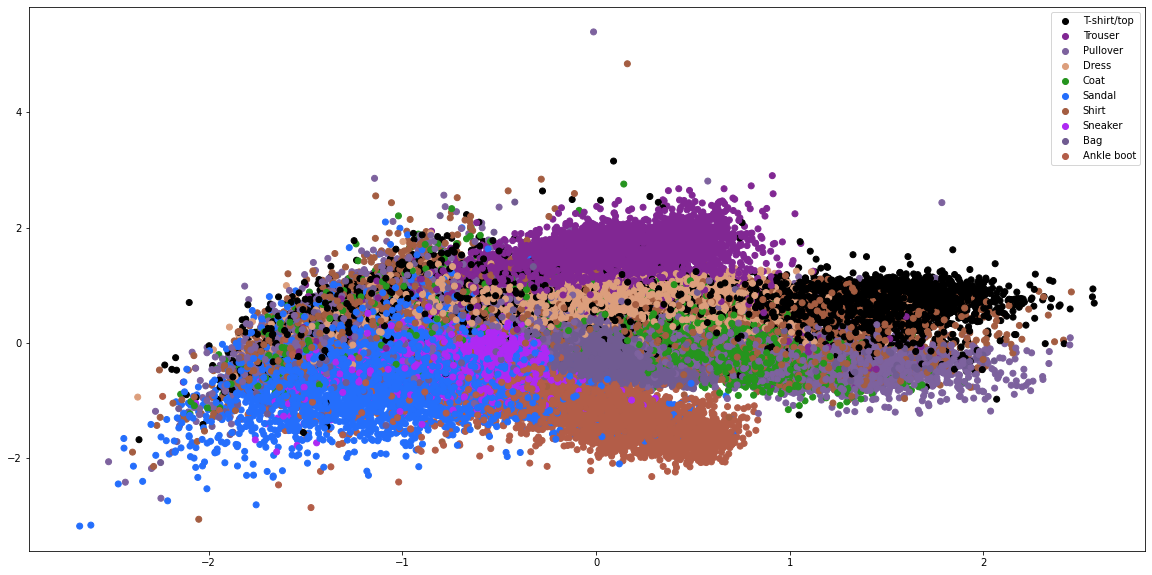

In [47]:
fig = plt.figure(figsize=(20,10))
scatter=plt.scatter(latent_val[:,0],latent_val[:,1],c=labels,cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=list(train_dataset.classes[int(a)] for a in np.unique(labels)))
plt.show()

In [48]:
classes = np.unique(labels)
sums = np.zeros(len(classes))
for i,clas in enumerate(classes):
    print((labels==clas).sum(),"many pictures of class:",train_dataset.classes[int(clas)])

6000 many pictures of class: T-shirt/top
6000 many pictures of class: Trouser
6000 many pictures of class: Pullover
6000 many pictures of class: Dress
6000 many pictures of class: Coat
6000 many pictures of class: Sandal
6000 many pictures of class: Shirt
6000 many pictures of class: Sneaker
6000 many pictures of class: Bag
6000 many pictures of class: Ankle boot


#### Visualize classes

In [ ]:
# TODO

## Appendix [OPTIONAL]

Use standard MNIST or CIFAR-10 instead of fashion MNIST.

In [ ]:
transform = transforms.Compose([ 
               transforms.Resize(image_size),
                transforms.ToTensor(),
               transforms.Normalize((0.1307,), (0.3081,))
            ])

train_dataset = datasets.MNIST(data_dir, train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(data_dir, train=False, transform=transforms.ToTensor())